In [1]:
from data_loader import DataLoader
import xgboost as xgb
import pandas as pd
import numpy as np
import os
import sys
from ml_util import *

dl = DataLoader('../data/')
x, y = dl.x, dl.y
data = np.hstack([x,np.reshape(y, (-1,1))])

data.shape

(125419, 122)

In [2]:
seq_length = 32
batch_size =512
def GetSamplePool(data, seq_length=seq_length):
    r = []
    for i in range(len(data)-seq_length):
        if np.isnan(data[i:i+32]).sum() == 0 and np.isinf(data[i:i+32]).sum() == 0:
            r.append(data[i:i+32])
    return np.array(r)
            
data_pool = GetSamplePool(data)
data_pool.shape

(79819, 32, 122)

In [3]:
from sklearn.model_selection import train_test_split

train_x,  test_x, train_y, test_y = train_test_split(data_pool[:,:,:-1], data_pool[:,-1,-1], test_size=0.2, random_state=1)
train_x, valid_x, train_y,  valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1)
train_y = np.reshape(train_y, (-1, 1))
valid_y = np.reshape(valid_y, (-1, 1))
test_y = np.reshape(test_y, (-1, 1))
train_x.shape, valid_x.shape, test_x.shape, train_y.shape, valid_y.shape, test_y.shape

((51084, 32, 121),
 (12771, 32, 121),
 (15964, 32, 121),
 (51084, 1),
 (12771, 1),
 (15964, 1))

In [4]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(np.reshape(y>0, (-1,1)))


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None,
       dtype=<type 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)

In [5]:
# lstm model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import activations
import tensorflow as tf

def focal_loss(pred, real,gamma=2):
    L=-real*((1-pred)**gamma)*tf.log(pred+1e-15)
    L=tf.reduce_sum(L,axis=1)
    return L

def lstm_model():
    model = keras.Sequential()
    #model.add(layers.Dense(50, activation='relu', input_dim = dl.x.shape[1])),#, return_sequences=True))
    #model.add(layers.Flatten())
    model.add(layers.LSTM(50, input_shape=(seq_length, dl.x.shape[1]),return_sequences=False))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(2, name='out'))
    model.add(layers.Activation('sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
        #optimizer=keras.optimizers.SGD(1e-2),
        loss=keras.losses.CategoricalCrossentropy(),
        #loss = focal_loss,
        metrics=['accuracy'])
    return model

model = lstm_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                34400     
_________________________________________________________________
dense (Dense)                (None, 30)                1530      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
out (Dense)                  (None, 2)                 42        
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 36,592
Trainable params: 36,592
Non-trainable params: 0
_________________________________________________________________


In [6]:
'''
from numpy import random
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(np.reshape(dl.y>0, (-1,1)))

def GenSeqSamples(x, y, batch_size=64, seq_length=32):
    count = 0
    rx, ry, index = [], [], []
    while count < batch_size:
        i = random.randint(len(x)-seq_length) #, size=batch_size)
        tx, ty = x[i:i+seq_length], y[i+seq_length-1]
        if np.isnan(tx).sum() != 0 or np.isnan(ty).sum() != 0:
            continue
        rx.append(tx)
        ry.append(ohe.transform(np.reshape(ty>0,(-1, 1))).toarray()[0])
        index.append(i)
        count += 1
    return np.array(rx), np.array(ry), np.array(index)
    
# filter data: remove those nan and inf
def Filter(x, y):
    nan_cond = (~np.isnan(y)) & (np.isnan(x).sum(axis=1) == 0)
    inf_cond = (~np.isinf(y)) & (np.isinf(x).sum(axis=1) == 0)
    return x[nan_cond & inf_cond], y[nan_cond * inf_cond]
    #print(x.shape, y_shape, rx.shape, ry.shape)
'''

'\nfrom numpy import random\nfrom sklearn.preprocessing import OneHotEncoder\nohe = OneHotEncoder()\nohe.fit(np.reshape(dl.y>0, (-1,1)))\n\ndef GenSeqSamples(x, y, batch_size=64, seq_length=32):\n    count = 0\n    rx, ry, index = [], [], []\n    while count < batch_size:\n        i = random.randint(len(x)-seq_length) #, size=batch_size)\n        tx, ty = x[i:i+seq_length], y[i+seq_length-1]\n        if np.isnan(tx).sum() != 0 or np.isnan(ty).sum() != 0:\n            continue\n        rx.append(tx)\n        ry.append(ohe.transform(np.reshape(ty>0,(-1, 1))).toarray()[0])\n        index.append(i)\n        count += 1\n    return np.array(rx), np.array(ry), np.array(index)\n    \n# filter data: remove those nan and inf\ndef Filter(x, y):\n    nan_cond = (~np.isnan(y)) & (np.isnan(x).sum(axis=1) == 0)\n    inf_cond = (~np.isinf(y)) & (np.isinf(x).sum(axis=1) == 0)\n    return x[nan_cond & inf_cond], y[nan_cond * inf_cond]\n    #print(x.shape, y_shape, rx.shape, ry.shape)\n'

In [7]:
#xt, yt, _ = GenSeqSamples(x_train, y_train)#, 1, 1)
#xt.shape, yt.shape

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=10)
#ohe.transform(train_y).toarray().shape
model.fit(train_x, ohe.transform(train_y>0).toarray(), batch_size = batch_size,
          validation_data=[valid_x, ohe.transform(valid_y>0).toarray()],
          callbacks=[earlystop_callback], epochs=30)
    #print(model.predict(xt[:num]), yt[:num], GetMidRes(model, 'out', xt[:num]))
    #if np.isnan(model.predict(xt[:num])).sum() > 0:
    #print(xt[:num], yt[:num], index, model.predict(xt[:num]))
    #raw_input()
    #break

Train on 51084 samples, validate on 12771 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
51084/51084 [==============================] - 16s 306us/sample - loss: 0.6097 - acc: 0.6627 - val_loss: 0.5763 - val_acc: 0.6967
Epoch 2/30
51084/51084 [==============================] - 14s 283us/sample - loss: 0.5698 - acc: 0.7014 - val_loss: 0.5705 - val_acc: 0.7035
Epoch 3/30
51084/51084 [==============================] - 17s 334us/sample - loss: 0.5602 - acc: 0.7098 - val_loss: 0.5693 - val_acc: 0.7004
Epoch 4/30
51084/51084 [==============================] - 16s 314us/sample - loss: 0.5518 - acc: 0.7161 - val_loss: 0.5680 - val_acc: 0.7071
Epoch 5/30
51084/51084 [==============================] - 16s 310us/sample - loss: 0.5422 - acc: 0.7230 - val_loss: 0.5673 - val_acc: 0.7069
Epoch 6/30
51084/51084 [==============================] - 16s 322us/sample - loss: 0.5325 - acc: 0.7311 - val_loss: 0.5724 - val_acc: 0.7072
Epoch 7/30

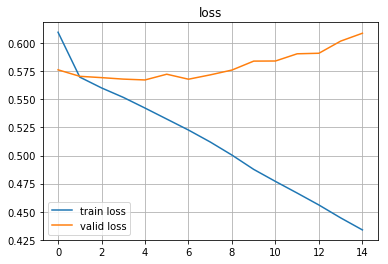

In [10]:
h = model.history.history
train_loss, valid_loss  = h['loss'], h['val_loss']
plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')
plt.title('loss')
plt.legend()
plt.grid()
plt.show()

Confusion matrix, without normalization


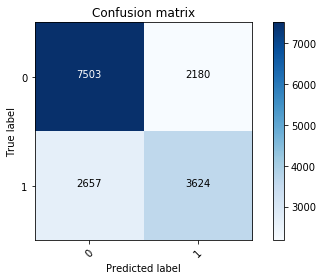

              precision    recall  f1-score   support

      class0       0.74      0.77      0.76      9683
      class1       0.62      0.58      0.60      6281

   micro avg       0.70      0.70      0.70     15964
   macro avg       0.68      0.68      0.68     15964
weighted avg       0.69      0.70      0.69     15964



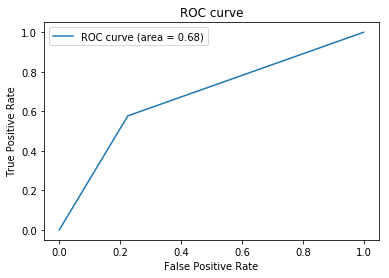

In [9]:
from ml_util import *
pred = model.predict(test_x)
pred.shape
(pred.argmax(axis=1) == 0).mean()
a = ClsReport(model,  test_y> 0, pred.argmax(axis=1), binary=True)